In [2]:
# This script loads a pretrained VGG16 model from torchvision and sets it for evaluation or training mode.

import torch

import torchvision.models as models



# Load the pretrained VGG16 model from torchvision's model library

vgg16 = models.vgg16(pretrained=True)



# Set the model to evaluation mode to disable certain layers like dropout for inference

vgg16.eval()



# If you are planning to fine-tune the model on a custom dataset, set it to training mode

vgg16.train()


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 213MB/s]  


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [4]:
# Custom implementation of a modified VGG16 model for classification with a customizable number of output classes.

import torch

import torch.nn as nn

import torchvision.models as models



class CustomVGG16(nn.Module):

    def __init__(self, num_classes=2):

        super(CustomVGG16, self).__init__()



        # Load the pre-trained VGG16 model from torchvision

        vgg16 = models.vgg16(pretrained=True)



        # Extract the feature extraction part and the average pooling layer from the pre-trained model

        self.features = vgg16.features

        self.avgpool = vgg16.avgpool



        # Create a new fully connected classifier tailored for the number of output classes

        self.classifier = nn.Sequential(

            nn.Linear(512 * 7 * 7, 4096),  # First fully connected layer; input size matches avgpool output

            nn.ReLU(inplace=True),  # Activation function to add non-linearity

            nn.Dropout(),  # Dropout layer for regularization

            nn.Linear(4096, 4096),  # Second fully connected layer

            nn.ReLU(inplace=True),  # Activation function to add non-linearity

            nn.Dropout(),  # Dropout layer for regularization

            nn.Linear(4096, num_classes)  # Final layer to produce output matching the number of classes

        )



    def forward(self, x):

        # Forward pass through the feature extraction layers

        x = self.features(x)



        # Forward pass through the average pooling layer to reduce dimensionality

        x = self.avgpool(x)



        # Flatten the output to a 2D tensor to feed into the fully connected layers

        x = torch.flatten(x, 1)  # Flatten from (batch_size, 512, 7, 7) to (batch_size, 512*7*7)



        # Forward pass through the custom classifier

        x = self.classifier(x)



        return x




In [5]:
# Create an instance of the CustomVGG16 model with 2 output classes

model = CustomVGG16(num_classes=2)



# Print the model architecture to see the details of its layers

print(model)


CustomVGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, di

In [6]:
# Class to implement early stopping for model training, preventing overfitting and saving the best model.

import numpy as np
import torch



class EarlyStopping:

    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):

        """

        Initializes the EarlyStopping object with the specified parameters.



        Args:

            patience (int): Number of epochs to wait before stopping if no improvement occurs.

                            Default is 7.

            verbose (bool): Controls whether messages about validation loss improvements are printed.

                            Default is False.

            delta (float): Minimum change needed in validation loss to count as an improvement.

                            Default is 0.

            path (str): File path for saving the model when the validation loss improves.

                            Default is 'checkpoint.pt'.

            trace_func (function): Function used for printing log messages during training.

                            Default is the built-in print function.

        """

        self.patience = patience

        self.verbose = verbose

        self.counter = 0  # Counts epochs without validation loss improvement

        self.best_score = None  # Stores the best validation loss seen so far

        self.early_stop = False  # Flag indicating if training should stop

        self.val_loss_min = np.Inf  # Initial value to ensure comparison works in the first epoch

        self.delta = delta  # Threshold for considering an improvement

        self.path = path  # Path to save the model's state when validation loss drops

        self.trace_func = trace_func  # Function for outputting trace information



    def __call__(self, val_loss, model):

        """Evaluate validation loss and determine if early stopping should be triggered."""

        score = -val_loss  # Invert validation loss to simplify the comparison (lower is better)



        if self.best_score is None:

            # Save the initial model state as it’s the first evaluation

            self.best_score = score

            self.save_checkpoint(val_loss, model)

        elif score < self.best_score + self.delta:

            # No significant drop in validation loss; increment counter

            self.counter += 1

            self.trace_func(f"Early stopping counter: {self.counter} of {self.patience}")

            if self.counter >= self.patience:

                # Stop training if patience is exceeded without improvement

                self.early_stop = True

        else:

            # Validation loss improved; update the best score and reset counter

            self.best_score = score

            self.save_checkpoint(val_loss, model)

            self.counter = 0



    def save_checkpoint(self, val_loss, model):

        """Save the model's state if there is an improvement in validation loss."""

        if self.verbose:

            self.trace_func(f"Validation loss reduced from {self.val_loss_min:.6f} to {val_loss:.6f}. Saving the model.")

        torch.save(model.state_dict(), self.path)

        self.val_loss_min = val_loss  # Update the minimum validation loss


In [7]:
# Import necessary libraries for building and training a deep learning model

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import time

In [8]:
# Define image size and paths for the dataset directories

img_size = 224

train_dir = '/kaggle/input/mri-dataset/Dataset_MRI/train'

val_dir = '/kaggle/input/mri-dataset/Dataset_MRI/val'

test_dir = '/kaggle/input/mri-dataset/Dataset_MRI/test'



# Data transformations for preprocessing and augmentation

data_transforms = {

    'train': transforms.Compose([

        transforms.RandomResizedCrop(img_size),  # Random crop and resize for data augmentation

        transforms.RandomHorizontalFlip(),  # Random horizontal flip for robustness

        transforms.ToTensor(),  # Convert image to a tensor

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet stats

    ]),

    'val': transforms.Compose([

        transforms.Resize(256),  # Resize the image to a consistent size

        transforms.CenterCrop(img_size),  # Center crop to the desired image size

        transforms.ToTensor(),  # Convert image to a tensor

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet stats

    ]),

    'test': transforms.Compose([

        transforms.Resize(256),  # Resize the image for consistency

        transforms.CenterCrop(img_size),  # Center crop to the desired image size

        transforms.ToTensor(),  # Convert image to a tensor

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with ImageNet stats

    ]),

}



# Load datasets for training, validation, and testing

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])

val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])

test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])



# Create data loaders for each dataset

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



# Function to create a modified VGG16 model for custom classification tasks

def create_vgg16_model(num_classes):

    model = models.vgg16(pretrained=True)  # Load the pre-trained VGG16 model



    # Freeze the feature extraction layers to retain learned features

    for param in model.features.parameters():

        param.requires_grad = False



    # Adjust the final layer to match the number of target classes

    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)



    return model



# Function to train the VGG16 model with early stopping and validation monitoring

def train_vgg16(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=5):

    model = model.to(device)

    best_accuracy = 0.0

    best_model_wts = model.state_dict()

    early_stop_counter = 0  # Counter to track epochs without improvement



    for epoch in range(num_epochs):

        print(f"Epoch {epoch + 1}/{num_epochs}")



        # Training phase: model learns from the training data

        model.train()

        running_loss = 0.0

        running_corrects = 0



        for inputs, labels in train_loader:

            inputs, labels = inputs.to(device), labels.to(device)



            optimizer.zero_grad()  # Clear previous gradients



            # Forward pass: calculate model output

            outputs = model(inputs)

            loss = criterion(outputs, labels)



            # Backward pass: compute gradients and update weights

            loss.backward()

            optimizer.step()



            # Accumulate loss and correct predictions

            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)



        # Calculate average loss and accuracy for this epoch

        epoch_loss = running_loss / len(train_loader.dataset)

        epoch_acc = running_corrects.double() / len(train_loader.dataset)



        print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")



        # Validation phase: evaluate model performance on validation set

        model.eval()

        val_running_loss = 0.0

        val_running_corrects = 0



        with torch.no_grad():

            for inputs, labels in val_loader:

                inputs, labels = inputs.to(device), labels.to(device)



                # Forward pass for validation

                outputs = model(inputs)

                loss = criterion(outputs, labels)



                # Accumulate validation loss and correct predictions

                val_running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)

                val_running_corrects += torch.sum(preds == labels.data)



        # Calculate average loss and accuracy for the validation set

        val_loss = val_running_loss / len(val_loader.dataset)

        val_acc = val_running_corrects.double() / len(val_loader.dataset)



        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")



        # Check for improvement and handle early stopping

        if val_acc > best_accuracy:

            best_accuracy = val_acc

            best_model_wts = model.state_dict()

            early_stop_counter = 0  # Reset counter if improvement is seen

        else:

            early_stop_counter += 1



        if early_stop_counter >= patience:

            print("Early stopping triggered due to lack of improvement.")

            break



    # Load the model with the best validation accuracy

    model.load_state_dict(best_model_wts)

    torch.save(model.state_dict(), 'best_vgg16_model.pth')  # Save the model weights

    print(f"Best Validation Accuracy: {best_accuracy:.4f}")



# Function to evaluate the trained model on the test set

def test_vgg16(model, test_loader, device):

    model.eval()

    test_corrects = 0

    with torch.no_grad():

        for inputs, labels in test_loader:

            inputs, labels = inputs.to(device), labels.to(device)



            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)

            test_corrects += torch.sum(preds == labels.data)



    test_acc = test_corrects.double() / len(test_loader.dataset)

    print(f"Test Accuracy: {test_acc:.4f}")



# Set up the computing device (GPU if available, otherwise CPU)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Prepare the model, loss function, and optimizer for training

num_classes = len(train_dataset.classes)

model = create_vgg16_model(num_classes)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)



# Train the model with early stopping based on validation performance

train_vgg16(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, patience=5)



# Load the best saved model and evaluate it on the test set

model.load_state_dict(torch.load('best_vgg16_model.pth'))

test_vgg16(model, test_loader, device)


Epoch 1/50
Training Loss: 0.4757, Training Accuracy: 0.7726
Validation Loss: 0.3321, Validation Accuracy: 0.8582
Epoch 2/50
Training Loss: 0.4321, Training Accuracy: 0.7920
Validation Loss: 0.3638, Validation Accuracy: 0.8431
Epoch 3/50
Training Loss: 0.4050, Training Accuracy: 0.8054
Validation Loss: 0.4039, Validation Accuracy: 0.8215
Epoch 4/50
Training Loss: 0.3950, Training Accuracy: 0.8123
Validation Loss: 0.3075, Validation Accuracy: 0.8562
Epoch 5/50
Training Loss: 0.3821, Training Accuracy: 0.8179
Validation Loss: 0.3233, Validation Accuracy: 0.8336
Epoch 6/50
Training Loss: 0.3757, Training Accuracy: 0.8239
Validation Loss: 0.4999, Validation Accuracy: 0.7717
Early stopping triggered due to lack of improvement.
Best Validation Accuracy: 0.8582


/tmp/ipykernel_30/1183416267.py:319: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_vgg16_model.pth'))


Test Accuracy: 0.7341


In [9]:
# Import required libraries for building and training the model

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import time



# Set image size and define paths for training, validation, and test data

img_size = 224

train_dir = '/kaggle/input/mri-dataset/Dataset_MRI/train'

val_dir = '/kaggle/input/mri-dataset/Dataset_MRI/val'

test_dir = '/kaggle/input/mri-dataset/Dataset_MRI/test'



# Define transformations for data augmentation and normalization

data_transforms = {

    'train': transforms.Compose([

        transforms.RandomResizedCrop(img_size),  # Randomly crop and resize images for data diversity

        transforms.RandomHorizontalFlip(),  # Apply random horizontal flipping to increase robustness

        transforms.ToTensor(),  # Convert image to PyTorch tensor

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with standard ImageNet values

    ]),

    'val': transforms.Compose([

        transforms.Resize(256),  # Resize image to a fixed size

        transforms.CenterCrop(img_size),  # Center crop to the target size

        transforms.ToTensor(),  # Convert image to PyTorch tensor

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with standard ImageNet values

    ]),

    'test': transforms.Compose([

        transforms.Resize(256),  # Resize image to a fixed size for consistency

        transforms.CenterCrop(img_size),  # Center crop to the target size

        transforms.ToTensor(),  # Convert image to PyTorch tensor

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize with standard ImageNet values

    ]),

}



# Load the datasets with the defined transformations

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])

val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])

test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])



# Create data loaders for training, validation, and testing

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



# Function to initialize a ResNet-50 model for custom classification tasks

def create_resnet50_model(num_classes):

    model = models.resnet50(pretrained=True)  # Load the pre-trained ResNet-50 model from torchvision



    # Freeze the weights of all convolutional layers to prevent updates during training

    for param in model.parameters():

        param.requires_grad = False



    # Modify the final fully connected layer to match the number of output classes

    num_ftrs = model.fc.in_features

    model.fc = nn.Linear(num_ftrs, num_classes)



    return model



# Function to train the ResNet-50 model with early stopping based on validation performance

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=5):

    model = model.to(device)

    best_accuracy = 0.0

    best_model_wts = model.state_dict()

    early_stop_counter = 0  # Counter for early stopping to monitor validation improvements



    for epoch in range(num_epochs):

        print(f"Epoch {epoch + 1}/{num_epochs}")



        # Training phase: optimize the model on training data

        model.train()

        running_loss = 0.0

        running_corrects = 0



        for inputs, labels in train_loader:

            inputs, labels = inputs.to(device), labels.to(device)



            # Clear the previous gradients

            optimizer.zero_grad()



            # Forward pass: calculate model predictions and loss

            outputs = model(inputs)

            loss = criterion(outputs, labels)



            # Backward pass: compute gradients and update model parameters

            loss.backward()

            optimizer.step()



            # Accumulate loss and correct predictions for training metrics

            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)



        # Calculate average training loss and accuracy for the epoch

        epoch_loss = running_loss / len(train_loader.dataset)

        epoch_acc = running_corrects.double() / len(train_loader.dataset)



        print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")



        # Validation phase: evaluate the model's performance on the validation set

        model.eval()

        val_running_loss = 0.0

        val_running_corrects = 0



        with torch.no_grad():

            for inputs, labels in val_loader:

                inputs, labels = inputs.to(device), labels.to(device)



                # Forward pass for validation data

                outputs = model(inputs)

                loss = criterion(outputs, labels)



                # Accumulate validation loss and correct predictions

                val_running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)

                val_running_corrects += torch.sum(preds == labels.data)



        # Calculate average validation loss and accuracy for the epoch

        val_loss = val_running_loss / len(val_loader.dataset)

        val_acc = val_running_corrects.double() / len(val_loader.dataset)



        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")



        # Save the model if its validation accuracy is the highest so far

        if val_acc > best_accuracy:

            best_accuracy = val_acc

            best_model_wts = model.state_dict()

            early_stop_counter = 0  # Reset early stopping counter if validation improves

        else:

            early_stop_counter += 1



        # Stop training if no improvement for 'patience' epochs

        if early_stop_counter >= patience:

            print("Early stopping triggered due to no improvement in validation accuracy.")

            break



    # Restore the best model weights and save the model to disk

    model.load_state_dict(best_model_wts)

    torch.save(model.state_dict(), 'best_resnet50_model.pth')

    print(f"Best Validation Accuracy: {best_accuracy:.4f}")



# Function to evaluate the trained model on the test dataset

def test_model(model, test_loader, device):

    model.eval()

    test_corrects = 0

    with torch.no_grad():

        for inputs, labels in test_loader:

            inputs, labels = inputs.to(device), labels.to(device)



            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)

            test_corrects += torch.sum(preds == labels.data)



    # Calculate and print the test accuracy

    test_acc = test_corrects.double() / len(test_loader.dataset)

    print(f"Test Accuracy: {test_acc:.4f}")



# Set the computation device (use GPU if available, otherwise CPU)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Prepare the model, loss function, and optimizer

num_classes = len(train_dataset.classes)

model = create_resnet50_model(num_classes)

criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification

optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)  # Optimizer for fine-tuning the fully connected layer



# Train the model with early stopping based on validation performance

train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, patience=5)



# Load the model with the best validation accuracy for final evaluation

model.load_state_dict(torch.load('best_resnet50_model.pth'))



# Evaluate the model on the test set

test_model(model, test_loader, device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 189MB/s] 


Epoch 1/50
Training Loss: 0.5528, Training Accuracy: 0.7299
Validation Loss: 0.3909, Validation Accuracy: 0.8436
Epoch 2/50
Training Loss: 0.5274, Training Accuracy: 0.7445
Validation Loss: 0.3755, Validation Accuracy: 0.8638
Epoch 3/50
Training Loss: 0.5201, Training Accuracy: 0.7469
Validation Loss: 0.3632, Validation Accuracy: 0.8532
Epoch 4/50
Training Loss: 0.5134, Training Accuracy: 0.7527
Validation Loss: 0.3718, Validation Accuracy: 0.8622
Epoch 5/50
Training Loss: 0.5086, Training Accuracy: 0.7535
Validation Loss: 0.3684, Validation Accuracy: 0.8627
Epoch 6/50
Training Loss: 0.5024, Training Accuracy: 0.7591
Validation Loss: 0.3793, Validation Accuracy: 0.8602
Epoch 7/50
Training Loss: 0.5056, Training Accuracy: 0.7556
Validation Loss: 0.3721, Validation Accuracy: 0.8658
Epoch 8/50
Training Loss: 0.5021, Training Accuracy: 0.7599
Validation Loss: 0.3823, Validation Accuracy: 0.8557
Epoch 9/50
Training Loss: 0.4999, Training Accuracy: 0.7569
Validation Loss: 0.3929, Validation 

/tmp/ipykernel_30/3741732062.py:343: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_resnet50_model.pth'))


Test Accuracy: 0.7308


In [10]:
# This script trains and evaluates a ResNet-18 model for image classification on a breast cancer dataset.

# The model uses transfer learning with early stopping to ensure optimal training.



import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import time



# Define image size and paths to the dataset directories

img_size = 224

train_dir = '/kaggle/input/mri-dataset/Dataset_MRI/train'

val_dir = '/kaggle/input/mri-dataset/Dataset_MRI/val'

test_dir = '/kaggle/input/mri-dataset/Dataset_MRI/test'



# Define data transformations for training, validation, and testing

data_transforms = {

    'train': transforms.Compose([

        transforms.RandomResizedCrop(img_size),  # Randomly resize and crop the image

        transforms.RandomHorizontalFlip(),  # Apply random horizontal flip for augmentation

        transforms.ToTensor(),  # Convert image to a PyTorch tensor

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize pixel values

    ]),

    'val': transforms.Compose([

        transforms.Resize(256),  # Resize the image for validation

        transforms.CenterCrop(img_size),  # Center crop to the desired size

        transforms.ToTensor(),  # Convert image to a tensor

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize pixel values

    ]),

    'test': transforms.Compose([

        transforms.Resize(256),  # Resize the image for testing

        transforms.CenterCrop(img_size),  # Center crop to the desired size

        transforms.ToTensor(),  # Convert image to a tensor

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize pixel values

    ]),

}



# Load the training, validation, and testing datasets using ImageFolder

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])

val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])

test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])



# Create data loaders for each dataset

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



# Function to initialize a ResNet-18 model for the specified number of classes

def create_resnet18_model(num_classes):

    model = models.resnet18(pretrained=True)  # Load a pre-trained ResNet-18 model



    # Set all convolutional layers to non-trainable

    for param in model.parameters():

        param.requires_grad = False



    # Update the final fully connected layer for the number of output classes

    num_ftrs = model.fc.in_features

    model.fc = nn.Linear(num_ftrs, num_classes)



    return model



# Function to train the ResNet-18 model with early stopping

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=5):

    model = model.to(device)

    best_accuracy = 0.0

    best_model_wts = model.state_dict()

    early_stop_counter = 0



    for epoch in range(num_epochs):

        print(f"Epoch {epoch + 1}/{num_epochs}")



        # Training loop

        model.train()

        running_loss = 0.0

        running_corrects = 0



        for inputs, labels in train_loader:

            inputs, labels = inputs.to(device), labels.to(device)



            # Reset gradients before the backward pass

            optimizer.zero_grad()



            # Perform forward pass

            outputs = model(inputs)

            loss = criterion(outputs, labels)



            # Backpropagation and optimization step

            loss.backward()

            optimizer.step()



            # Accumulate loss and correct predictions

            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)



        # Calculate and print training statistics

        epoch_loss = running_loss / len(train_loader.dataset)

        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")



        # Validation loop

        model.eval()

        val_running_loss = 0.0

        val_running_corrects = 0



        with torch.no_grad():

            for inputs, labels in val_loader:

                inputs, labels = inputs.to(device), labels.to(device)



                # Forward pass for validation

                outputs = model(inputs)

                loss = criterion(outputs, labels)



                # Track validation loss and accuracy

                val_running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)

                val_running_corrects += torch.sum(preds == labels.data)



        # Compute validation loss and accuracy

        val_loss = val_running_loss / len(val_loader.dataset)

        val_acc = val_running_corrects.double() / len(val_loader.dataset)

        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")



        # Save the best model based on validation accuracy

        if val_acc > best_accuracy:

            best_accuracy = val_acc

            best_model_wts = model.state_dict()

            early_stop_counter = 0  # Reset early stopping counter

        else:

            early_stop_counter += 1



        # Trigger early stopping if the patience threshold is met

        if early_stop_counter >= patience:

            print("Early stopping triggered.")

            break



    # Load the model with the best validation accuracy

    model.load_state_dict(best_model_wts)

    torch.save(model.state_dict(), 'best_resnet18_model.pth')

    print(f"Best Validation Accuracy: {best_accuracy:.4f}")



# Function to evaluate the model on the test set

def test_model(model, test_loader, device):

    model.eval()

    test_corrects = 0

    with torch.no_grad():

        for inputs, labels in test_loader:

            inputs, labels = inputs.to(device), labels.to(device)



            # Forward pass for testing

            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)

            test_corrects += torch.sum(preds == labels.data)



    # Calculate and print test accuracy

    test_acc = test_corrects.double() / len(test_loader.dataset)

    print(f"Test Accuracy: {test_acc:.4f}")



# Set the computation device (GPU if available, otherwise CPU)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Initialize the model, loss function, and optimizer

num_classes = len(train_dataset.classes)

model = create_resnet18_model(num_classes)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)



# Train the model with early stopping for the defined number of epochs

train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, patience=5)



# Load the best model and evaluate on the test set

model.load_state_dict(torch.load('best_resnet18_model.pth'))

test_model(model, test_loader, device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]


Epoch 1/50
Training Loss: 0.5589, Training Accuracy: 0.7314
Validation Loss: 0.4182, Validation Accuracy: 0.8451
Epoch 2/50
Training Loss: 0.5368, Training Accuracy: 0.7427
Validation Loss: 0.4245, Validation Accuracy: 0.8391
Epoch 3/50
Training Loss: 0.5243, Training Accuracy: 0.7474
Validation Loss: 0.4222, Validation Accuracy: 0.8341
Epoch 4/50
Training Loss: 0.5173, Training Accuracy: 0.7527
Validation Loss: 0.4009, Validation Accuracy: 0.8401
Epoch 5/50
Training Loss: 0.5122, Training Accuracy: 0.7521
Validation Loss: 0.4491, Validation Accuracy: 0.8125
Epoch 6/50
Training Loss: 0.5120, Training Accuracy: 0.7557
Validation Loss: 0.4123, Validation Accuracy: 0.8270
Early stopping triggered.
Best Validation Accuracy: 0.8451


/tmp/ipykernel_30/3211408023.py:340: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_resnet18_model.pth'))


Test Accuracy: 0.7574


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
Training Loss: 0.4823, Training Accuracy: 0.7662
Validation Loss: 0.3745, Validation Accuracy: 0.8457
Epoch 2/50
Training Loss: 0.4324, Training Accuracy: 0.7900
Validation Loss: 0.4660, Validation Accuracy: 0.7672
Epoch 3/50
Training Loss: 0.4122, Training Accuracy: 0.8014
Validation Loss: 0.3611, Validation Accuracy: 0.8311
Epoch 4/50
Training Loss: 0.3965, Training Accuracy: 0.8111
Validation Loss: 0.3616, Validation Accuracy: 0.8371
Epoch 5/50
Training Loss: 0.3844, Training Accuracy: 0.8183
Validation Loss: 0.5459, Validation Accuracy: 0.7431
Epoch 6/50
Training Loss: 0.3754, Training Accuracy: 0.8226
Validation Loss: 0.3589, Validation Accuracy: 0.8582
Epoch 7/50
Training Loss: 0.3714, Training Accuracy: 0.8232
Validation Loss: 0.3720, Validation Accuracy: 0.8321
Epoch 8/50
Training Loss: 0.3576, Training Accuracy: 0.8329
Validation Loss: 0.2936, Validation Accuracy: 0.8638
Epoch 9/50
Training Loss: 0.3492, Training Accuracy: 0.8381
Validation Loss: 0.3799, Validation 

/tmp/ipykernel_30/1932536682.py:431: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_vgg16_model.pth'))


Test Accuracy: 0.7533


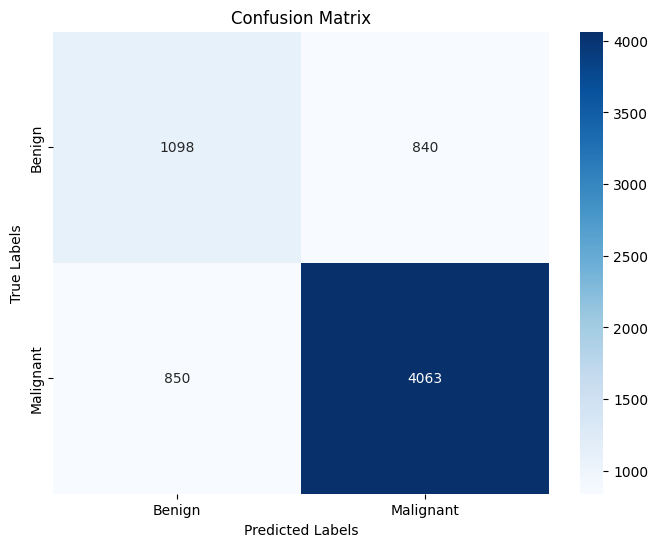

ROC AUC Score: 0.7842


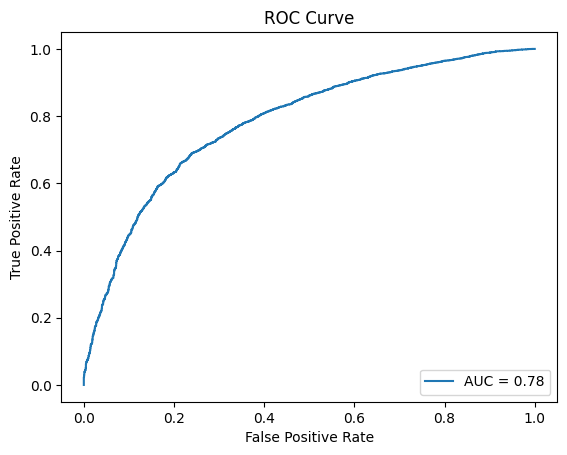

In [11]:
# This script defines and trains a VGG-16 model for image classification, evaluates it on test data, and plots performance metrics.

# The model is trained with early stopping and its performance is assessed using confusion matrix and ROC AUC curve.



import torch

import torch.nn as nn

import torch.optim as optim

from torchvision import datasets, models, transforms

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

import seaborn as sns



# Helper functions

def plot_auc(y_true, y_scores):

    """Plot the ROC AUC curve and display the ROC AUC score."""

    auc_score = roc_auc_score(y_true, y_scores)

    print(f"ROC AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(y_true, y_scores)

    plt.figure()

    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")

    plt.xlabel('False Positive Rate')

    plt.ylabel('True Positive Rate')

    plt.title('ROC Curve')

    plt.legend(loc='lower right')

    plt.show()



def plot_confusion_matrix(y_true, y_pred, classes):

    """Plot and display the confusion matrix."""

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

    plt.xlabel('Predicted Labels')

    plt.ylabel('True Labels')

    plt.title('Confusion Matrix')

    plt.show()



# Model creation function

def create_vgg16_model(num_classes):

    """Create a VGG-16 model for the given number of classes with transfer learning."""

    model = models.vgg16(pretrained=True)



    # Freeze the convolutional layers to retain the pre-trained weights

    for param in model.features.parameters():

        param.requires_grad = False



    # Replace the final layer with a new classifier for the number of classes

    model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)



    return model



# Training function

def train_vgg16(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=5):

    """Train the VGG-16 model with early stopping based on validation accuracy."""

    model = model.to(device)

    best_accuracy = 0.0

    best_model_wts = model.state_dict()

    early_stop_counter = 0



    for epoch in range(num_epochs):

        print(f"Epoch {epoch + 1}/{num_epochs}")



        # Training phase

        model.train()

        running_loss = 0.0

        running_corrects = 0



        for inputs, labels in train_loader:

            inputs, labels = inputs.to(device), labels.to(device)



            # Zero the parameter gradients before each backpropagation

            optimizer.zero_grad()



            # Forward pass to compute predictions and loss

            outputs = model(inputs)

            loss = criterion(outputs, labels)



            # Backward pass to calculate gradients and update weights

            loss.backward()

            optimizer.step()



            # Track statistics for loss and accuracy

            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)



        # Calculate average loss and accuracy for this epoch

        epoch_loss = running_loss / len(train_loader.dataset)

        epoch_acc = running_corrects.double() / len(train_loader.dataset)



        print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")



        # Validation phase

        model.eval()

        val_running_loss = 0.0

        val_running_corrects = 0



        with torch.no_grad():

            for inputs, labels in val_loader:

                inputs, labels = inputs.to(device), labels.to(device)



                # Forward pass for validation data

                outputs = model(inputs)

                loss = criterion(outputs, labels)



                # Track validation loss and accuracy

                val_running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)

                val_running_corrects += torch.sum(preds == labels.data)



        # Calculate validation loss and accuracy

        val_loss = val_running_loss / len(val_loader.dataset)

        val_acc = val_running_corrects.double() / len(val_loader.dataset)



        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")



        # Save the best model if it achieves better validation accuracy

        if val_acc > best_accuracy:

            best_accuracy = val_acc

            best_model_wts = model.state_dict()

            early_stop_counter = 0  # Reset early stopping counter when validation improves

        else:

            early_stop_counter += 1



        # Check for early stopping condition

        if early_stop_counter >= patience:

            print("Early stopping triggered.")

            break



    # Restore the model to the best performing state

    model.load_state_dict(best_model_wts)

    torch.save(model.state_dict(), 'best_vgg16_model.pth')

    print(f"Best Validation Accuracy: {best_accuracy:.4f}")



# Testing function

def test_vgg16(model, test_loader, device, class_names):

    """Evaluate the model on test data and plot performance metrics."""

    model.eval()

    test_corrects = 0

    all_labels = []

    all_preds = []

    all_probs = []



    with torch.no_grad():

        for inputs, labels in test_loader:

            inputs, labels = inputs.to(device), labels.to(device)



            # Get model predictions and probabilities for the test data

            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)

            probs = torch.softmax(outputs, dim=1)[:, 1]  # Assuming binary classification



            test_corrects += torch.sum(preds == labels.data)

            all_labels.extend(labels.cpu().numpy())

            all_preds.extend(preds.cpu().numpy())

            all_probs.extend(probs.cpu().numpy())



    # Calculate and print test accuracy

    test_acc = test_corrects.double() / len(test_loader.dataset)

    print(f"Test Accuracy: {test_acc:.4f}")



    # Plot the confusion matrix to show prediction performance

    plot_confusion_matrix(all_labels, all_preds, class_names)



    # Plot the ROC AUC curve for model's performance evaluation

    plot_auc(all_labels, all_probs)



# Main workflow

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img_size = 224



# Dataset paths

train_dir = '/kaggle/input/mri-dataset/Dataset_MRI/train'

val_dir = '/kaggle/input/mri-dataset/Dataset_MRI/val'

test_dir = '/kaggle/input/mri-dataset/Dataset_MRI/test'



# Data augmentation and preprocessing for training, validation, and test sets

data_transforms = {

    'train': transforms.Compose([

        transforms.RandomResizedCrop(img_size),  # Augmentation for training: resize and crop

        transforms.RandomHorizontalFlip(),  # Data augmentation: random horizontal flip

        transforms.ToTensor(),  # Convert image to a PyTorch tensor

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize pixel values

    ]),

    'val': transforms.Compose([

        transforms.Resize(256),  # Resize for validation

        transforms.CenterCrop(img_size),  # Center crop to desired size

        transforms.ToTensor(),  # Convert image to a tensor

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize pixel values

    ]),

    'test': transforms.Compose([

        transforms.Resize(256),  # Resize for test data

        transforms.CenterCrop(img_size),  # Center crop to desired size

        transforms.ToTensor(),  # Convert image to a tensor

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize pixel values

    ]),

}



# Load datasets and create data loaders

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])

val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])

test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])



train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



# Initialize model, loss function, and optimizer

num_classes = len(train_dataset.classes)

class_names = train_dataset.classes

model = create_vgg16_model(num_classes)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001)



# Train and evaluate the model

train_vgg16(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, patience=5)

model.load_state_dict(torch.load('best_vgg16_model.pth'))

test_vgg16(model, test_loader, device, class_names)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
Training Loss: 0.5575, Training Accuracy: 0.7291
Validation Loss: 0.3988, Validation Accuracy: 0.8527
Epoch 2/50
Training Loss: 0.5300, Training Accuracy: 0.7412
Validation Loss: 0.3996, Validation Accuracy: 0.8617
Epoch 3/50
Training Loss: 0.5222, Training Accuracy: 0.7490
Validation Loss: 0.3888, Validation Accuracy: 0.8648
Epoch 4/50
Training Loss: 0.5161, Training Accuracy: 0.7523
Validation Loss: 0.3800, Validation Accuracy: 0.8632
Epoch 5/50
Training Loss: 0.5107, Training Accuracy: 0.7553
Validation Loss: 0.3744, Validation Accuracy: 0.8708
Epoch 6/50
Training Loss: 0.5064, Training Accuracy: 0.7558
Validation Loss: 0.3773, Validation Accuracy: 0.8643
Epoch 7/50
Training Loss: 0.5114, Training Accuracy: 0.7549
Validation Loss: 0.3727, Validation Accuracy: 0.8678
Epoch 8/50
Training Loss: 0.5027, Training Accuracy: 0.7564
Validation Loss: 0.3810, Validation Accuracy: 0.8597
Epoch 9/50
Training Loss: 0.5053, Training Accuracy: 0.7570
Validation Loss: 0.3762, Validation 

/tmp/ipykernel_30/1101877275.py:427: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_resnet50_model.pth'))


Test Accuracy: 0.7254


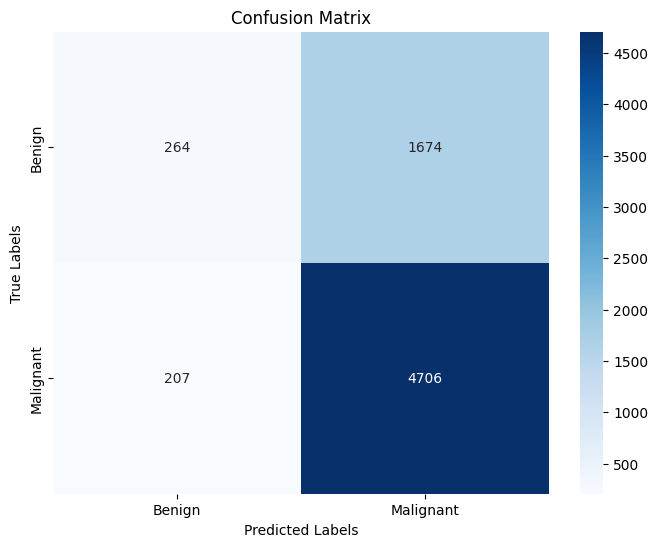

ROC AUC Score: 0.7339


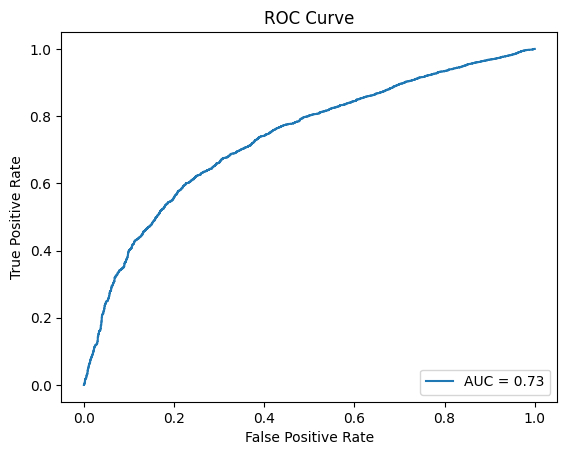

In [12]:
# This code implements training, validation, and testing of a ResNet-50 model for image classification using PyTorch.

# It includes functions for plotting metrics such as confusion matrix and ROC AUC curve, and it utilizes early stopping

# for training to prevent overfitting.



import torch

import torch.nn as nn

import torch.optim as optim

from torchvision import datasets, models, transforms

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

import seaborn as sns



# Helper functions to visualize evaluation metrics

def plot_auc(y_true, y_scores):

    """Plot the ROC AUC curve for model performance evaluation."""

    auc_score = roc_auc_score(y_true, y_scores)

    print(f"ROC AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(y_true, y_scores)

    plt.figure()

    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")

    plt.xlabel('False Positive Rate')

    plt.ylabel('True Positive Rate')

    plt.title('ROC Curve')

    plt.legend(loc='lower right')

    plt.show()



def plot_confusion_matrix(y_true, y_pred, classes):

    """Generate a confusion matrix heatmap to visualize classification performance."""

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

    plt.xlabel('Predicted Labels')

    plt.ylabel('True Labels')

    plt.title('Confusion Matrix')

    plt.show()



# Model creation function for ResNet-50 with custom classification head

def create_resnet50_model(num_classes):

    """Build a ResNet-50 model with a modified fully connected layer."""

    model = models.resnet50(pretrained=True)



    # Freeze all layers except the fully connected (classification) layer

    for param in model.parameters():

        param.requires_grad = False



    # Replace the classification layer to match the number of classes

    model.fc = nn.Linear(model.fc.in_features, num_classes)



    return model



# Function to train the ResNet-50 model with early stopping

def train_resnet50(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=5):

    """Train the ResNet-50 model and implement early stopping based on validation accuracy."""

    model = model.to(device)

    best_accuracy = 0.0

    best_model_wts = model.state_dict()

    early_stop_counter = 0



    for epoch in range(num_epochs):

        print(f"Epoch {epoch + 1}/{num_epochs}")



        # Training phase

        model.train()

        running_loss = 0.0

        running_corrects = 0



        for inputs, labels in train_loader:

            inputs, labels = inputs.to(device), labels.to(device)



            # Zero the gradients for each batch

            optimizer.zero_grad()



            # Forward pass

            outputs = model(inputs)

            loss = criterion(outputs, labels)



            # Backward pass and optimization step

            loss.backward()

            optimizer.step()



            # Track training statistics

            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)



        # Calculate epoch loss and accuracy for training

        epoch_loss = running_loss / len(train_loader.dataset)

        epoch_acc = running_corrects.double() / len(train_loader.dataset)



        print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")



        # Validation phase

        model.eval()

        val_running_loss = 0.0

        val_running_corrects = 0



        with torch.no_grad():

            for inputs, labels in val_loader:

                inputs, labels = inputs.to(device), labels.to(device)



                # Forward pass for validation

                outputs = model(inputs)

                loss = criterion(outputs, labels)



                # Track validation statistics

                val_running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)

                val_running_corrects += torch.sum(preds == labels.data)



        # Calculate validation loss and accuracy

        val_loss = val_running_loss / len(val_loader.dataset)

        val_acc = val_running_corrects.double() / len(val_loader.dataset)



        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")



        # Save the model if it has the best validation accuracy so far

        if val_acc > best_accuracy:

            best_accuracy = val_acc

            best_model_wts = model.state_dict()

            early_stop_counter = 0  # Reset counter when validation improves

        else:

            early_stop_counter += 1



        # Stop training if the patience limit is reached

        if early_stop_counter >= patience:

            print("Early stopping triggered.")

            break



    # Load the best model weights and save the model

    model.load_state_dict(best_model_wts)

    torch.save(model.state_dict(), 'best_resnet50_model.pth')

    print(f"Best Validation Accuracy: {best_accuracy:.4f}")



# Function to test the ResNet-50 model and plot metrics

def test_resnet50(model, test_loader, device, class_names):

    """Evaluate the model on the test set and display metrics like confusion matrix and ROC AUC curve."""

    model.eval()

    test_corrects = 0

    all_labels = []

    all_preds = []

    all_probs = []



    with torch.no_grad():

        for inputs, labels in test_loader:

            inputs, labels = inputs.to(device), labels.to(device)



            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)

            probs = torch.softmax(outputs, dim=1)[:, 1]  # Assumes binary classification



            test_corrects += torch.sum(preds == labels.data)

            all_labels.extend(labels.cpu().numpy())

            all_preds.extend(preds.cpu().numpy())

            all_probs.extend(probs.cpu().numpy())



    # Calculate test accuracy

    test_acc = test_corrects.double() / len(test_loader.dataset)

    print(f"Test Accuracy: {test_acc:.4f}")



    # Plot the confusion matrix and ROC AUC curve

    plot_confusion_matrix(all_labels, all_preds, class_names)

    plot_auc(all_labels, all_probs)



# Main execution workflow

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img_size = 224  # Set the image size for preprocessing



# Define the paths for the dataset directories

train_dir = '/kaggle/input/mri-dataset/Dataset_MRI/train'

val_dir = '/kaggle/input/mri-dataset/Dataset_MRI/val'

test_dir = '/kaggle/input/mri-dataset/Dataset_MRI/test'



# Define data transformations for training, validation, and testing

data_transforms = {

    'train': transforms.Compose([

        transforms.RandomResizedCrop(img_size),

        transforms.RandomHorizontalFlip(),

        transforms.ToTensor(),

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ]),

    'val': transforms.Compose([

        transforms.Resize(256),

        transforms.CenterCrop(img_size),

        transforms.ToTensor(),

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ]),

    'test': transforms.Compose([

        transforms.Resize(256),

        transforms.CenterCrop(img_size),

        transforms.ToTensor(),

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ]),

}



# Load datasets and create data loaders

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])

val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])

test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])



train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



# Prepare the model, criterion, and optimizer

num_classes = len(train_dataset.classes)

class_names = train_dataset.classes

model = create_resnet50_model(num_classes)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)



# Train and test the model

train_resnet50(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, patience=5)

model.load_state_dict(torch.load('best_resnet50_model.pth'))

test_resnet50(model, test_loader, device, class_names)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50
Training Loss: 0.5698, Training Accuracy: 0.7212
Validation Loss: 0.4295, Validation Accuracy: 0.8396
Epoch 2/50
Training Loss: 0.5373, Training Accuracy: 0.7384
Validation Loss: 0.4072, Validation Accuracy: 0.8386
Epoch 3/50
Training Loss: 0.5281, Training Accuracy: 0.7483
Validation Loss: 0.4031, Validation Accuracy: 0.8381
Epoch 4/50
Training Loss: 0.5219, Training Accuracy: 0.7511
Validation Loss: 0.3947, Validation Accuracy: 0.8386
Epoch 5/50
Training Loss: 0.5157, Training Accuracy: 0.7534
Validation Loss: 0.3942, Validation Accuracy: 0.8371
Epoch 6/50
Training Loss: 0.5087, Training Accuracy: 0.7546
Validation Loss: 0.3894, Validation Accuracy: 0.8326
Early stopping triggered.
Best Validation Accuracy: 0.8396


/tmp/ipykernel_30/2969799954.py:433: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_resnet18_model.pth'))


Test Accuracy: 0.7422


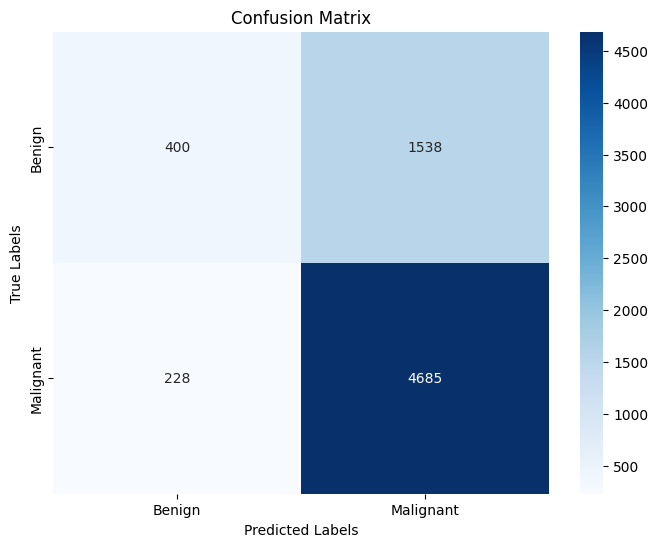

ROC AUC Score: 0.7212


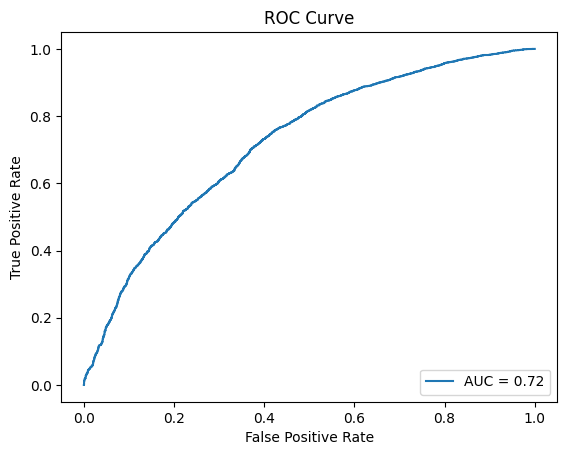

In [13]:
# This script trains and evaluates a ResNet-18 model for binary image classification.
# It includes data preparation, model training with early stopping, and performance visualization.


import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

# Helper function to plot the ROC AUC curve

def plot_auc(y_true, y_scores):

    """Plot the ROC AUC curve and display the AUC score."""

    auc_score = roc_auc_score(y_true, y_scores)

    print(f"ROC AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(y_true, y_scores)

    plt.figure()

    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")

    plt.xlabel('False Positive Rate')

    plt.ylabel('True Positive Rate')

    plt.title('ROC Curve')

    plt.legend(loc='lower right')

    plt.show()



# Helper function to plot the confusion matrix

def plot_confusion_matrix(y_true, y_pred, classes):

    """Display the confusion matrix as a heatmap for better visualization."""

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

    plt.xlabel('Predicted Labels')

    plt.ylabel('True Labels')

    plt.title('Confusion Matrix')

    plt.show()



# Model creation function for ResNet-18

def create_resnet18_model(num_classes):

    """Build a ResNet-18 model with a customized fully connected layer for classification."""

    model = models.resnet18(pretrained=True)



    # Freeze all convolutional layers to avoid updating their weights during training

    for param in model.parameters():

        param.requires_grad = False



    # Replace the final fully connected layer to match the number of classes

    model.fc = nn.Linear(model.fc.in_features, num_classes)



    return model



# Function for training the ResNet-18 model

def train_resnet18(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10, patience=5):

    """Train the ResNet-18 model with early stopping based on validation accuracy."""

    model = model.to(device)

    best_accuracy = 0.0

    best_model_wts = model.state_dict()

    early_stop_counter = 0



    for epoch in range(num_epochs):

        print(f"Epoch {epoch + 1}/{num_epochs}")



        # Training phase: model learns from the training data

        model.train()

        running_loss = 0.0

        running_corrects = 0



        for inputs, labels in train_loader:

            inputs, labels = inputs.to(device), labels.to(device)



            # Zero the parameter gradients for each batch

            optimizer.zero_grad()



            # Forward pass: compute model predictions

            outputs = model(inputs)

            loss = criterion(outputs, labels)



            # Backward pass and optimization step

            loss.backward()

            optimizer.step()



            # Accumulate loss and calculate the number of correct predictions

            running_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)



        # Calculate and print training loss and accuracy for the epoch

        epoch_loss = running_loss / len(train_loader.dataset)

        epoch_acc = running_corrects.double() / len(train_loader.dataset)



        print(f"Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}")



        # Validation phase: evaluate model performance on validation set

        model.eval()

        val_running_loss = 0.0

        val_running_corrects = 0



        with torch.no_grad():

            for inputs, labels in val_loader:

                inputs, labels = inputs.to(device), labels.to(device)



                # Forward pass: no gradient calculation needed for validation

                outputs = model(inputs)

                loss = criterion(outputs, labels)



                # Accumulate loss and track the number of correct predictions

                val_running_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)

                val_running_corrects += torch.sum(preds == labels.data)



        # Calculate and print validation loss and accuracy for the epoch

        val_loss = val_running_loss / len(val_loader.dataset)

        val_acc = val_running_corrects.double() / len(val_loader.dataset)



        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")



        # Check if the current model is the best so far and save it if so

        if val_acc > best_accuracy:

            best_accuracy = val_acc

            best_model_wts = model.state_dict()

            early_stop_counter = 0  # Reset the counter if validation improves

        else:

            early_stop_counter += 1



        # Stop training early if the validation accuracy does not improve for a set number of epochs

        if early_stop_counter >= patience:

            print("Early stopping triggered.")

            break



    # Load the best model weights and save the model to a file

    model.load_state_dict(best_model_wts)

    torch.save(model.state_dict(), 'best_resnet18_model.pth')

    print(f"Best Validation Accuracy: {best_accuracy:.4f}")



# Function for evaluating the model on the test set

def test_resnet18(model, test_loader, device, class_names):

    """Evaluate the trained model and visualize the test metrics."""

    model.eval()

    test_corrects = 0

    all_labels = []

    all_preds = []

    all_probs = []



    with torch.no_grad():

        for inputs, labels in test_loader:

            inputs, labels = inputs.to(device), labels.to(device)



            # Forward pass to get predictions and probabilities

            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)

            probs = torch.softmax(outputs, dim=1)[:, 1]  # Assuming binary classification



            test_corrects += torch.sum(preds == labels.data)

            all_labels.extend(labels.cpu().numpy())

            all_preds.extend(preds.cpu().numpy())

            all_probs.extend(probs.cpu().numpy())



    # Calculate and display test accuracy

    test_acc = test_corrects.double() / len(test_loader.dataset)

    print(f"Test Accuracy: {test_acc:.4f}")



    # Plot confusion matrix for test predictions

    plot_confusion_matrix(all_labels, all_preds, class_names)



    # Plot the ROC AUC curve for test predictions

    plot_auc(all_labels, all_probs)



# Main script for loading data, training, and testing

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

img_size = 224  # Image size for model input



# Directories for the dataset

train_dir = '/kaggle/input/mri-dataset/Dataset_MRI/train'

val_dir = '/kaggle/input/mri-dataset/Dataset_MRI/val'

test_dir = '/kaggle/input/mri-dataset/Dataset_MRI/test'



# Data transformation pipelines for training, validation, and testing

data_transforms = {

    'train': transforms.Compose([

        transforms.RandomResizedCrop(img_size),

        transforms.RandomHorizontalFlip(),

        transforms.ToTensor(),

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ]),

    'val': transforms.Compose([

        transforms.Resize(256),

        transforms.CenterCrop(img_size),

        transforms.ToTensor(),

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ]),

    'test': transforms.Compose([

        transforms.Resize(256),

        transforms.CenterCrop(img_size),

        transforms.ToTensor(),

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ]),

}



# Load datasets and create data loaders for training, validation, and testing

train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])

val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])

test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])



train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



# Set up model, criterion, and optimizer

num_classes = len(train_dataset.classes)

class_names = train_dataset.classes

model = create_resnet18_model(num_classes)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)



# Train the model and evaluate its performance

train_resnet18(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=50, patience=5)

model.load_state_dict(torch.load('best_resnet18_model.pth'))

test_resnet18(model, test_loader, device, class_names)


In [14]:
pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 30.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 99.2 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: tomlkit
    Found existing installation: tomlkit 0.13.2
    Uninstalling tomlkit-0.13.2:
      Successfully uninstalled tomlkit-0.13.2
  Attempting uninstall: python-multipart
    Found existing installation: python-multipart 0.0.9
    Uninstalling python-multipart-0.0.9:
      Successfully uninstalled python-multipart-0.0.9
  Attempting uninstall: starlette
    Found existing installation: starlette 0.37.2
    Uninstalling starlette-0.37.2:
      Successfully uninstalled starlette-0.37.2
  Attempting uninstall: fastapi
    Found existing installation: f

In [15]:
# This script sets up a Gradio interface for classifying breast cancer images using pre-trained ResNet models.

# The app allows users to upload images and select between two models (ResNet18 or ResNet50) for classification.



import gradio as gr

from PIL import Image

import torch

import torch.nn as nn

from torchvision import models, transforms



# Function to dynamically load a pre-trained model with specified weights

def load_model(model_name, model_path):

    """Load a ResNet model (ResNet18 or ResNet50) and set it to evaluation mode with pre-trained weights."""

    if model_name == "ResNet18":

        model = models.resnet18(pretrained=False)  # Initialize ResNet18 without pretrained weights

        model.fc = nn.Linear(model.fc.in_features, 2)  # Modify fully connected layer for binary classification

    elif model_name == "ResNet50":

        model = models.resnet50(pretrained=False)  # Initialize ResNet50 without pretrained weights

        model.fc = nn.Linear(model.fc.in_features, 2)  # Modify fully connected layer for binary classification

    else:

        raise ValueError("Invalid model name. Please select either 'ResNet18' or 'ResNet50'.")



    # Load the model's state dict from the specified file path and set it to evaluation mode

    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

    model.eval()

    return model



# Image preprocessing function to prepare images for model input

def preprocess_image(image):

    """Transform input image for the model, including resizing, cropping, and normalization."""

    transform = transforms.Compose([

        transforms.Resize(256),  # Resize image to 256 pixels on the shorter side

        transforms.CenterCrop(224),  # Crop the image to 224x224 pixels

        transforms.ToTensor(),  # Convert image to PyTorch tensor

        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize using ImageNet mean and std

    ])

    return transform(image).unsqueeze(0)  # Add batch dimension



# Function to predict the class of an input image using the selected model

def predict(image, model_name):

    """Make a prediction using the chosen model and return a formatted response string."""

    image = Image.fromarray(image)  # Convert numpy array input to PIL image format

    input_tensor = preprocess_image(image)  # Preprocess the input image



    # Dictionary mapping model names to their corresponding weight file paths

    model_paths = {

        "ResNet18": "/kaggle/working/best_resnet18_model.pth",

        "ResNet50": "/kaggle/working/best_resnet50_model.pth"

    }



    # Load the specified model with its pre-trained weights

    model_path = model_paths[model_name]

    model = load_model(model_name, model_path)



    with torch.no_grad():  # No gradient calculation needed for inference

        outputs = model(input_tensor)  # Get model predictions

        probabilities = torch.softmax(outputs, dim=1)[0]  # Convert raw outputs to probabilities



        # Extract individual class probabilities and determine the predicted class

        benign_prob = probabilities[0].item()

        malignant_prob = probabilities[1].item()

        predicted_idx = probabilities.argmax().item()

        predicted_class = class_names[predicted_idx]  # Map index to class name



    # Format the prediction response for user display

    response = (

        f"Model: {model_name}\n"

        f"Predicted Class: {predicted_class}\n"

        f"Benign Probability: {benign_prob:.2f}\n"

        f"Malignant Probability: {malignant_prob:.2f}"

    )

    return response



# Global variable for class names

class_names = ["benign", "malignant"]  # Define the labels for binary classification



# Set up the Gradio interface with specified input and output components

interface = gr.Interface(

    fn=predict,

    inputs=[

        gr.Image(type="numpy", label="Upload Image"),  # Input for image upload

        gr.Radio(["ResNet18", "ResNet50"], label="Select Model")  # Input for model selection

    ],

    outputs=gr.Textbox(label="Prediction"),  # Output displaying prediction results

    title="Breast Cancer Classification",  # Title of the app

    description="Upload an image and select a model (ResNet18 or ResNet50) to classify it as benign or malignant."  # Description of the app functionality

)



# Launch the Gradio app interface

interface.launch()


* Running on local URL:  http://127.0.0.1:7860
Kaggle notebooks require sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://ceea02ad0148d779f9.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_30/4136958381.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the function